In [1]:
%aiida

Loaded AiiDA DB environment.

In [6]:
code = load_code("qe-6.5-pw@localhost")

In [7]:
builder = code.get_builder()

In [8]:
builder.metadata.label = "PW test"
builder.metadata.description = "Li on Graphene"

In [9]:
builder.metadata.options.resources = {'num_machines': 1}
builder.metadata.options.max_wallclock_seconds = 30 * 60

## Create K-points

In [10]:
KpointsData = DataFactory('array.kpoints')
kpoints = KpointsData()
kpoints_mesh = 2
kpoints.set_kpoints_mesh([kpoints_mesh] * 3)
kpoints.store()

<KpointsData: uuid: 4b71a9bc-6b80-4b3c-8cdb-a21a456b0a39 (pk: 2304)>

## Structure

In [11]:
import pymatgen as mg
import numpy as np
import random
from itertools import cycle
from pymatgen import Structure, Lattice, MPRester, Molecule
from pymatgen.analysis.adsorption import *
import matplotlib.pyplot as plt

In [13]:
a = 2.46 # graphene lattice
lattice = np.sqrt(3)*a # paper lattice
a_ = a/np.sqrt(3)
struct = Structure.from_spacegroup("P6/mmm",
                            Lattice.hexagonal(lattice,5),
                            ["C"],
                            [[1/3, 0, 1/2]]
                           )

In [14]:
asf = AdsorbateSiteFinder(struct)
sites = asf.find_adsorption_sites()

def classify_site(coord, slab):
    site_dists = slab.get_sites_in_sphere(coord, 7)
    min_dist = min([site_dist[1] for site_dist in site_dists])
    ensemble = slab.get_sites_in_sphere(coord, min_dist * 1.15)  # probably should tweak this
    ensemble_size = len(ensemble)
    if ensemble_size == 1:
        return "ontop"
    elif ensemble_size == 2:
        return "bridge"
    else:
        return "{}-fold hollow".format(ensemble_size)
   
newsites = {}
for site in sites['all']:
    newsites[classify_site(site, struct)] = site
#         newsites[site] = {classify_site(site, struct):site}

    
ontop = Structure(struct.lattice,'O',[newsites['ontop']],coords_are_cartesian=True)
hollow = Structure(struct.lattice,'O',[newsites['6-fold hollow']],coords_are_cartesian=True)
bridge = Structure(struct.lattice,'O',[newsites['bridge']],coords_are_cartesian=True)

In [15]:
hollow.translate_sites([0],[2/3,1/3,0],to_unit_cell=False)
hollow2 = hollow

hollow = Structure(struct.lattice,'O',[newsites['6-fold hollow']],coords_are_cartesian=True)

hollow.translate_sites([0],[1/3,2/3,0],to_unit_cell=False)
hollow3 = hollow

hollow = Structure(struct.lattice,'O',[newsites['6-fold hollow']],coords_are_cartesian=True)

ads = hollow
ads.insert(1,'O',list(hollow2.cart_coords[0]),coords_are_cartesian=True)
ads.insert(2,'O',list(hollow3.cart_coords[0]),coords_are_cartesian=True)

ads2 = ads*(1,1,1)
ads2.translate_sites(range(0,3),[0,0,-4],frac_coords=False,to_unit_cell=False)

In [16]:
M = 2
N = 2
n_ads = 5

struct_super = struct*(M,N,1)
ads_super = ads2*(M,N,1)

# index_value = random.sample(list(enumerate(l)), 2)
# random_list = random.sample(list(ads_super.cart_coords),n_ads)
index_coords = random.sample(list(enumerate(ads_super.cart_coords)), n_ads)

indexes = []
coords = []
for idx, coord in index_coords:
    indexes.append(idx)
    coords.append(coord)

for site in coords:
    struct_super.append('Li',site, coords_are_cartesian=True)
print(indexes)
# view2D(struct_super)

[8, 10, 4, 2, 5]


In [17]:
StructureData = DataFactory("structure")
# from_mol      = StructureData(pymatgen=mol)
from_struct   = StructureData(pymatgen=struct_super)

In [19]:
from_struct

<StructureData: uuid: 57167edd-8e7b-49c8-bdf5-584d7dc6b2bf (unstored)>

In [54]:
from ase.spacegroup import crystal
ase_structure = crystal('Si', [(0, 0, 0)], spacegroup=227,
             cellpar=[alat, alat, alat, 90, 90, 90], primitive_cell=True)
structure = StructureData(ase=ase_structure)

## Builder

In [20]:
builder.structure = from_struct
builder.kpoints = kpoints

In [29]:
!verdi data upf listfamilies -h

Usage: verdi data upf listfamilies [OPTIONS] [--]

  List all UPF families that exist in the database.

Options:
  -d, --with-description       Show also the description for the UPF family
  -e, --with-elements TEXT...  Only select objects containing these elements.
  -h, --help                   Show this message and exit.


In [25]:
from aiida.orm.nodes.data.upf import get_pseudos_from_structure
builder.pseudos = get_pseudos_from_structure(from_struct, 'GBRV_lda')

NotExistent: No UPF for element C found in family GBRV_lda

In [57]:
builder.pseudos

{'Si': <UpfData: uuid: 59814d74-4d3a-43ee-8a2a-22b7f88b9594 (pk: 367)>}

In [23]:
!verdi data upf listfamilies

Success: * GBRV_lda [33 pseudos]
Success: * GBRV_pbe [33 pseudos]
Success: * GBRV_pbesol [33 pseudos]


### Parameters

In [58]:
parameters_dict = {
    "CONTROL": {
        "calculation": "scf",
    },
    "SYSTEM": {
        "ecutwfc": 30.,
        "ecutrho": 200.,
    },
    "ELECTRONS": {
        "conv_thr": 1.e-6,
    }
}


In [59]:
builder.parameters = Dict(dict=parameters_dict)

### RUN

In [60]:
builder.metadata.dry_run = True
builder.metadata.store_provenance = False

In [61]:
from aiida.engine import run
run(builder)

{}

In [64]:
ls submit_test/

20200406-00001/  20200406-00002/  20200406-00003/  20200412-00001/


In [65]:
builder.metadata.dry_run = False
builder.metadata.store_provenance = True

In [66]:
from aiida.engine import submit
calculation = submit(builder)

In [ ]:
!verdi process list

In [68]:
!verdi process list -a -p1

  PK  Created    Process label    Process State    Process status
----  ---------  ---------------  ---------------  ----------------
2040  2m ago     PwCalculation    ⏹ Finished [0]

Total results: 1

Info: last time an entry changed state: 2m ago (at 01:40:41 on 2020-04-12)


In [69]:
!verdi process show 2040

Property     Value
-----------  -----------------------------------------------
type         PwCalculation
state        Finished [0]
pk           2040
uuid         f94b05be-c8e0-4055-8e29-999e2be3c214
label        PW test
description  My first AiiDA calc with Quantum ESPRESSO on Si
ctime        2020-04-12 01:40:22.964415+00:00
mtime        2020-04-12 01:40:42.160225+00:00
computer     [1] localhost

Inputs      PK    Type
----------  ----  -------------
pseudos
    Si      367   UpfData
code        1     Code
kpoints     2037  KpointsData
parameters  2039  Dict
structure   2038  StructureData

Outputs              PK  Type
-----------------  ----  --------------
output_band        2043  BandsData
output_parameters  2045  Dict
output_trajectory  2044  TrajectoryData
remote_folder      2041  RemoteData
retrieved          2042  FolderData


In [70]:
calculation = load_node(2040)

In [71]:
calculation.res.energy

-258.53730671697

In [72]:
calculation.outputs.output_parameters.attributes

{'lsda': False,
 'energy': -258.53730671697,
 'volume': 39.366,
 'fft_grid': [36, 36, 36],
 'energy_xc': -118.7002201301,
 'wall_time': '      2.82s ',
 'rho_cutoff': 2721.13834506,
 'symmetries': [{'t_rev': '0', 'symmetry_number': 0},
  {'t_rev': '0', 'symmetry_number': 1},
  {'t_rev': '0', 'symmetry_number': 2},
  {'t_rev': '0', 'symmetry_number': 3},
  {'t_rev': '0', 'symmetry_number': 4},
  {'t_rev': '0', 'symmetry_number': 5},
  {'t_rev': '0', 'symmetry_number': 6},
  {'t_rev': '0', 'symmetry_number': 7},
  {'t_rev': '0', 'symmetry_number': 8},
  {'t_rev': '0', 'symmetry_number': 9},
  {'t_rev': '0', 'symmetry_number': 10},
  {'t_rev': '0', 'symmetry_number': 11},
  {'t_rev': '0', 'symmetry_number': 12},
  {'t_rev': '0', 'symmetry_number': 13},
  {'t_rev': '0', 'symmetry_number': 14},
  {'t_rev': '0', 'symmetry_number': 15},
  {'t_rev': '0', 'symmetry_number': 16},
  {'t_rev': '0', 'symmetry_number': 17},
  {'t_rev': '0', 'symmetry_number': 18},
  {'t_rev': '0', 'symmetry_number':

## Workflow

In [73]:
from __future__ import absolute_import
def create_diamond_fcc(element):
    """Calculation function to create the crystal structure of a given element.

    For simplicity, only Si and Ge are valid elements.

    :param element: The element to create the structure with.
    :return: The structure.
    """
    from aiida import orm

    import numpy as np
    elem_alat = {
        'Si': 5.431,  # Angstrom
        'Ge': 5.658,  # Angstrom
    }

    # Validate input element
    try:
        symbol = element.value
    except AttributeError:
        symbol = str(element)

    if symbol not in elem_alat:
        raise ValueError('Valid elements are only Si and Ge')

    # Create cell starting having lattice parameter alat corresponding to the element
    alat = elem_alat[symbol]
    cell = np.array([[0., 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.]]) * alat

    # Create a structure data object
    structure = orm.StructureData(cell=cell)
    structure.append_atom(position=(0., 0., 0.), symbols=symbol)
    structure.append_atom(position=(0.25 * alat, 0.25 * alat, 0.25 * alat),
                          symbols=symbol)

    return structure

In [74]:
from __future__ import absolute_import
def rescale(structure, scale):
    """Calculation function to rescale a structure

    :param structure: An AiiDA structure to rescale
    :param scale: The scale factor (for the lattice constant)
    :return: The rescaled structure
    """
    from aiida import orm

    ase = structure.get_ase()
    ase.set_cell(ase.get_cell() * float(scale), scale_atoms=True)

    return orm.StructureData(ase=ase)

In [75]:
initial_structure = create_diamond_fcc('Si')
rescaled_structures = [rescale(initial_structure, factor) for factor in (0.98, 0.99, 1.0, 1.1, 1.2)]

In [76]:
initial_structure.store()
for structure in rescaled_structures:
   structure.store()

In [79]:
structure.get_incoming()

In [80]:
# Add this import
from aiida.engine import calcfunction

# Add decorators
@calcfunction
def create_diamond_fcc(element):
    """Calculation function to create the crystal structure of a given element.

    For simplicity, only Si and Ge are valid elements.

    :param element: The element to create the structure with.
    :return: The structure.
    """
    from aiida import orm

    import numpy as np
    elem_alat = {
        'Si': 5.431,  # Angstrom
        'Ge': 5.658,  # Angstrom
    }

    # Validate input element
    try:
        symbol = element.value
    except AttributeError:
        symbol = str(element)

    if symbol not in elem_alat:
        raise ValueError('Valid elements are only Si and Ge')

    # Create cell starting having lattice parameter alat corresponding to the element
    alat = elem_alat[symbol]
    cell = np.array([[0., 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.]]) * alat

    # Create a structure data object
    structure = orm.StructureData(cell=cell)
    structure.append_atom(position=(0., 0., 0.), symbols=symbol)
    structure.append_atom(position=(0.25 * alat, 0.25 * alat, 0.25 * alat),
                          symbols=symbol)

    return structure

@calcfunction
def rescale(structure, scale):
    """Calculation function to rescale a structure

    :param structure: An AiiDA structure to rescale
    :param scale: The scale factor (for the lattice constant)
    :return: The rescaled structure
    """
    from aiida import orm

    ase = structure.get_ase()
    ase.set_cell(ase.get_cell() * float(scale), scale_atoms=True)

    return orm.StructureData(ase=ase)

In [82]:
from aiida.orm import Float, Str
initial_structure = create_diamond_fcc(Str('Si'))
rescaled_structures = [rescale(initial_structure, Float(factor)) for factor in (0.98, 0.99, 1.0, 1.1, 1.2)]

In [83]:
initial_structure.get_outgoing().all_nodes()

[<CalcFunctionNode: uuid: 8e9842b6-b96c-4e41-8710-571d668d9218 (pk: 2074) (__main__.rescale)>,
 <CalcFunctionNode: uuid: d52e8779-a11c-4324-979d-e909037d52dc (pk: 2071) (__main__.rescale)>,
 <CalcFunctionNode: uuid: 95bf8f79-dfc8-4f01-9ad8-7feab301b718 (pk: 2068) (__main__.rescale)>,
 <CalcFunctionNode: uuid: ea2233a9-1270-495f-b17b-eba6f3903364 (pk: 2065) (__main__.rescale)>,
 <CalcFunctionNode: uuid: a8ce997e-77b9-4d9a-bcb4-76701ee088fe (pk: 2062) (__main__.rescale)>]

In [84]:
for structure in initial_structure.get_outgoing().all_nodes():
    print(structure.get_incoming().all_nodes())

[<Float: uuid: 045ea822-7f20-4494-9580-b67ab4c42dad (pk: 2073) value: 1.2>, <StructureData: uuid: 397e6941-af8e-4ecd-ad17-9586507e5b7e (pk: 2060)>]
[<Float: uuid: 40a0deda-7233-4e60-9a74-bfaf2295b1f1 (pk: 2070) value: 1.1>, <StructureData: uuid: 397e6941-af8e-4ecd-ad17-9586507e5b7e (pk: 2060)>]
[<Float: uuid: f1e244e6-4a8d-4384-b979-6d621b9c9134 (pk: 2067) value: 1.0>, <StructureData: uuid: 397e6941-af8e-4ecd-ad17-9586507e5b7e (pk: 2060)>]
[<Float: uuid: e153f3d1-10ff-4218-8ab1-4d4e83cc77f6 (pk: 2064) value: 0.99>, <StructureData: uuid: 397e6941-af8e-4ecd-ad17-9586507e5b7e (pk: 2060)>]
[<Float: uuid: 1b9c2f6d-513a-4905-87e4-f1884c1fae74 (pk: 2061) value: 0.98>, <StructureData: uuid: 397e6941-af8e-4ecd-ad17-9586507e5b7e (pk: 2060)>]


## Nest the two functions

In [87]:
from __future__ import absolute_import
from aiida.engine import workfunction


@workfunction
def create_rescaled(element, scale):
    """Workfunction to create and immediately rescale a crystal structure of a given element."""
    structure = create_diamond_fcc(element)
    rescaled = rescale(structure, scale)

    return rescaled

In [88]:
rescaled = create_rescaled(element=Str('Si'), scale=Float(0.98))

In [90]:
rescaled.get_incoming().all_nodes()

[<WorkFunctionNode: uuid: 9ea52613-785c-4b60-8f57-922448c8e7bb (pk: 2078) (__main__.create_rescaled)>,
 <CalcFunctionNode: uuid: c4fc0714-9d25-4151-85bd-a8e06dc80ea6 (pk: 2081) (__main__.rescale)>]

In [91]:
node = load_node(2078)
node.get_outgoing().all()

[LinkTriple(node=<StructureData: uuid: 9a5e8bd9-0f73-4586-93d7-c86208d394fb (pk: 2082)>, link_type=<LinkType.RETURN: 'return'>, link_label='result'),
 LinkTriple(node=<CalcFunctionNode: uuid: c4fc0714-9d25-4151-85bd-a8e06dc80ea6 (pk: 2081) (__main__.rescale)>, link_type=<LinkType.CALL_CALC: 'call_calc'>, link_label='CALL'),
 LinkTriple(node=<CalcFunctionNode: uuid: 0760dba3-bddb-42b5-b9ac-13b0bb2573ed (pk: 2079) (__main__.create_diamond_fcc)>, link_type=<LinkType.CALL_CALC: 'call_calc'>, link_label='CALL')]

In [92]:
!wget https://aiida-tutorials.readthedocs.io/en/latest/_downloads/48779d27ff46c36570bae0d4defc285d/common_wf.py

--2020-04-12 04:21:26--  https://aiida-tutorials.readthedocs.io/en/latest/_downloads/48779d27ff46c36570bae0d4defc285d/common_wf.py
Resolving aiida-tutorials.readthedocs.io (aiida-tutorials.readthedocs.io)... 104.208.221.96
Connecting to aiida-tutorials.readthedocs.io (aiida-tutorials.readthedocs.io)|104.208.221.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3177 (3.1K) [text/x-python]
Saving to: ‘common_wf.py’

common_wf.py        100%[===================>]   3.10K  --.-KB/s    in 0s      

2020-04-12 04:21:27 (759 MB/s) - ‘common_wf.py’ saved [3177/3177]



## Synchronous (serial) job

In [96]:
# -*- coding: utf-8 -*-
"""Simple workflow example"""
from __future__ import absolute_import
from __future__ import print_function
from six.moves import zip

from aiida.engine import run, Process, calcfunction, workfunction
from aiida.orm import load_code, Dict, Float, Str
from aiida.plugins import CalculationFactory

from create_rescale import create_diamond_fcc, rescale
from common_wf import generate_scf_input_params

# Load the calculation class 'PwCalculation' using its entry point 'quantumespresso.pw'
PwCalculation = CalculationFactory('quantumespresso.pw')


@calcfunction
def create_eos_dictionary(**kwargs):
    """Create a single `Dict` node from the `Dict` output parameters of completed `PwCalculations`.

    The dictionary will contain a list of tuples, where each tuple contains the volume, total energy and its units
    of the results of a calculation.

    :return: `Dict` node with the equation of state results
    """
    eos = [(result.dict.volume, result.dict.energy, result.dict.energy_units)
           for label, result in kwargs.items()]
    return Dict(dict={'eos': eos})


@workfunction
def run_eos_wf(code, pseudo_family, element):
    """Run an equation of state of a bulk crystal structure for the given element."""

    # This will print the pk of the work function
    print('Running run_eos_wf<{}>'.format(Process.current().pid))

    scale_factors = (0.96, 0.98, 1.0, 1.02, 1.04)
    labels = ['c1', 'c2', 'c3', 'c4', 'c5']

    calculations = {}

    # Create an initial bulk crystal structure for the given element, using the calculation function defined earlier
    initial_structure = create_diamond_fcc(element)

    # Loop over the label and scale_factor pairs
    for label, factor in list(zip(labels, scale_factors)):

        # Generated the scaled structure from the initial structure
        structure = rescale(initial_structure, Float(factor))

        # Generate the inputs for the `PwCalculation`
        inputs = generate_scf_input_params(structure, code, pseudo_family)

        # Launch a `PwCalculation` for each scaled structure
        print('Running a scf for {} with scale factor {}'.format(
            element, factor))
        calculations[label] = run(PwCalculation, **inputs)

    # Bundle the individual results from each `PwCalculation` in a single dictionary node.
    # Note: since we are 'creating' new data from existing data, we *have* to go through a `calcfunction`, otherwise
    # the provenance would be lost!
    inputs = {
        label: result['output_parameters']
        for label, result in calculations.items()
    }
    eos = create_eos_dictionary(**inputs)

    # Finally, return the results of this work function
    result = {'initial_structure': initial_structure, 'eos': eos}

    return result


def run_eos(code=load_code('qe-6.5-pw@localhost'),
            pseudo_family='GBRV_pbe',
            element='Si'):
    """Helper function to run EOS WorkChain."""
    return run_eos_wf(code, Str(pseudo_family), Str(element))


# if __name__ == '__main__':
#     run_eos()

In [98]:
run_eos()

Running run_eos_wf<2085>
Running a scf for uuid: 427c8b92-817c-4af3-b969-b046e0bd4b21 (pk: 2084) value: Si with scale factor 0.96
Running a scf for uuid: 427c8b92-817c-4af3-b969-b046e0bd4b21 (pk: 2084) value: Si with scale factor 0.98
Running a scf for uuid: 427c8b92-817c-4af3-b969-b046e0bd4b21 (pk: 2084) value: Si with scale factor 1.0
Running a scf for uuid: 427c8b92-817c-4af3-b969-b046e0bd4b21 (pk: 2084) value: Si with scale factor 1.02
Running a scf for uuid: 427c8b92-817c-4af3-b969-b046e0bd4b21 (pk: 2084) value: Si with scale factor 1.04


{'initial_structure': <StructureData: uuid: 778777c3-9c6f-44f2-ade0-5c2bf4e87415 (pk: 2087)>,
 'eos': <Dict: uuid: 1f5a4d2b-0280-452f-9a71-7dc01515ee95 (pk: 2144)>}

In [105]:
!verdi process show 2085

Property     Value
-----------  ------------------------------------
type         run_eos_wf
state        Finished [0]
pk           2085
uuid         d4f950ed-bc65-4996-aab9-30da2181810c
label        run_eos_wf
description
ctime        2020-04-12 02:32:09.618777+00:00
mtime        2020-04-12 02:33:06.519251+00:00
computer     [1] localhost

Inputs           PK  Type
-------------  ----  ------
code              1  Code
element        2084  Str
pseudo_family  2083  Str

Outputs              PK  Type
-----------------  ----  -------------
eos                2144  Dict
initial_structure  2087  StructureData

Called      PK  Type
--------  ----  ----------------
CALL      2143  CalcFunctionNode
CALL      2137  CalcJobNode
CALL      2133  CalcFunctionNode
CALL      2126  CalcJobNode
CALL      2122  CalcFunctionNode
CALL      2115  CalcJobNode
CALL      2111  CalcFunctionNode
CALL      2104  CalcJobNode
CALL      2100  CalcFunctionNode
CALL      2093  CalcJobNode
CALL      2089  CalcFunction

In [106]:
!verdi data dict show 2144

{
    "eos": [
        [
            35.431791867961,
            -258.06090178853,
            "eV"
        ],
        [
            37.692734388326,
            -258.38283286328,
            "eV"
        ],
        [
            40.04786949775,
            -258.58324388606,
            "eV"
        ],
        [
            42.499119493968,
            -258.68158841093,
            "eV"
        ],
        [
            45.048406674717,
            -258.69494892809,
            "eV"
        ]
    ]
}


## Async (Parallel) job

In [107]:
# -*- coding: utf-8 -*-
"""Simple workflow example"""
from __future__ import absolute_import
from __future__ import print_function
from six.moves import zip

from time import sleep
from aiida.engine import submit, Process, calcfunction, workfunction
from aiida.orm import load_code, Dict, Float, Str
from aiida.plugins import CalculationFactory

from create_rescale import create_diamond_fcc, rescale
from common_wf import generate_scf_input_params

# Load the calculation class 'PwCalculation' using its entry point 'quantumespresso.pw'
PwCalculation = CalculationFactory('quantumespresso.pw')


@calcfunction
def create_eos_dictionary(**kwargs):
    """Create a single `Dict` node from the `Dict` output parameters of completed `PwCalculations`.

    The dictionary will contain a list of tuples, where each tuple contains the volume, total energy and its units
    of the results of a calculation.

    :return: `Dict` node with the equation of state results
    """
    eos = [(result.dict.volume, result.dict.energy, result.dict.energy_units)
           for label, result in kwargs.items()]
    return Dict(dict={'eos': eos})


@workfunction
def run_eos_wf(code, pseudo_family, element):
    """Run an equation of state of a bulk crystal structure for the given element."""

    # This will print the pk of the work function
    print('Running run_eos_wf<{}>'.format(Process.current().pid))

    scale_factors = (0.96, 0.98, 1.0, 1.02, 1.04)
    labels = ['c1', 'c2', 'c3', 'c4', 'c5']

    calculations = {}

    # Create an initial bulk crystal structure for the given element, using the calculation function defined earlier
    initial_structure = create_diamond_fcc(element)

    # Loop over the label and scale_factor pairs
    for label, factor in list(zip(labels, scale_factors)):

        # Generated the scaled structure from the initial structure
        structure = rescale(initial_structure, Float(factor))

        # Generate the inputs for the `PwCalculation`
        inputs = generate_scf_input_params(structure, code, pseudo_family)

        # Launch a `PwCalculation` for each scaled structure
        print('Running a scf for {} with scale factor {}'.format(
            element, factor))
        calculations[label] = submit(PwCalculation, **inputs)

    # Bundle the individual results from each `PwCalculation` in a single dictionary node.
    # Note: since we are 'creating' new data from existing data, we *have* to go through a `calcfunction`, otherwise
    # the provenance would be lost!
    
    # Wait for the calculations to finish
    for calculation in calculations.values():
        while not calculation.is_finished:
            sleep(1)

    inputs = {label: node.get_outgoing().get_node_by_label('output_parameters') for label, node in calculations.items()}
    eos = create_eos_dictionary(**inputs)

    # Finally, return the results of this work function
    result = {'initial_structure': initial_structure, 'eos': eos}

    return result


def run_eos(code=load_code('qe-6.5-pw@localhost'),
            pseudo_family='GBRV_pbe',
            element='Si'):
    """Helper function to run EOS WorkChain."""
    return run_eos_wf(code, Str(pseudo_family), Str(element))


# if __name__ == '__main__':
#     run_eos()

In [108]:
run_eos()

Running run_eos_wf<2147>
Running a scf for uuid: a1c88d1d-558a-48f1-8ea0-9c064e1ddcb6 (pk: 2146) value: Si with scale factor 0.96
Running a scf for uuid: a1c88d1d-558a-48f1-8ea0-9c064e1ddcb6 (pk: 2146) value: Si with scale factor 0.98
Running a scf for uuid: a1c88d1d-558a-48f1-8ea0-9c064e1ddcb6 (pk: 2146) value: Si with scale factor 1.0
Running a scf for uuid: a1c88d1d-558a-48f1-8ea0-9c064e1ddcb6 (pk: 2146) value: Si with scale factor 1.02
Running a scf for uuid: a1c88d1d-558a-48f1-8ea0-9c064e1ddcb6 (pk: 2146) value: Si with scale factor 1.04


04/12/2020 04:59:23 AM <6244> aiida.orm.nodes.process.calculation.calcfunction.CalcFunctionNode: [REPORT] [2201|create_eos_dictionary|on_except]: Traceback (most recent call last):
  File "/home/max/codes/aiida-core/aiida/orm/implementation/django/nodes.py", line 179, in get_attribute
    return self._dbmodel.attributes[key]
KeyError: 'volume'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/max/.virtualenvs/aiida/lib/python3.6/site-packages/plumpy/process_states.py", line 220, in execute
    result = self.run_fn(*self.args, **self.kwargs)
  File "/home/max/codes/aiida-core/aiida/engine/processes/functions.py", line 408, in run
    result = self._func(*args, **kwargs)
  File "<ipython-input-107-3f46f510ba62>", line 29, in create_eos_dictionary
    for label, result in kwargs.items()]
  File "<ipython-input-107-3f46f510ba62>", line 29, in <listcomp>
    for label, result in kwargs.items()]
  File "/home/max/codes/aiid

AttributeError: attribute `'volume'` does not exist

In [2]:
import pymatgen
from pymatgen import Structure, Lattice

In [3]:
from ase_notebook import AseView, ViewConfig, get_example_atoms

# ase_view.config
config = ViewConfig()
ase_view = AseView(config)

ase_view = AseView(
    rotations="45x,45y,45z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2,
    show_bonds=True
)
# ase_view.config.uc_dash_pattern=(.6,.4)
# ase_view.add_miller_plane(
# #     1, 0, 0, color="green",
# 1,0,0, color="green")
# ase_view.config.canvas_color_background = "white"
# ase_view.config.canvas_background_opacity = 0.2
# gui = ase_view.make_render(
#     G, center_in_uc=True)
# gui

def view3D(structure,h,k,l):
    
    ase_view.config.uc_dash_pattern=(.6,.4)
    ase_view.add_miller_plane(
    #     1, 0, 0, color="green",
    h, k, l, color="green")
    ase_view.config.canvas_color_background = "white"
    ase_view.config.canvas_background_opacity = 0.2
    gui = ase_view.make_render(
        structure, center_in_uc=True)
    return gui

In [4]:
from ase_notebook import concatenate_svgs

def view2D(structure):
    svgs = []
    for rot in ["45x,45y,45z", "0x", "90x"]:
        ase_view.config.rotations = rot
        ase_view.add_miller_plane(
            1, 0, 0, color="green")
#         1,0,0, color="blue")
        svgs.append(
            ase_view.make_svg(structure, center_in_uc=True)
        )
    return concatenate_svgs(
        svgs, max_columns=3, scale=0.5, label=True
    )

In [37]:
lattice = Lattice.hexagonal(2.46,5)
G = Structure(lattice, ["C", "C"], [[1/3,2/3,1/2],[2/3,1/3,1/2]])
G

Structure Summary
Lattice
    abc : 2.46 2.46 5.0
 angles : 90.0 90.0 119.99999999999999
 volume : 26.20419666770955
      A : 2.46 0.0 1.5063155629512443e-16
      B : -1.2299999999999993 2.1304224933097196 1.5063155629512443e-16
      C : 0.0 0.0 5.0
PeriodicSite: C (0.0000, 1.4203, 2.5000) [0.3333, 0.6667, 0.5000]
PeriodicSite: C (1.2300, 0.7101, 2.5000) [0.6667, 0.3333, 0.5000]

In [38]:
view2D(G)

In [39]:
G.make_supercell([4,4,1])

In [8]:
view2D(G)

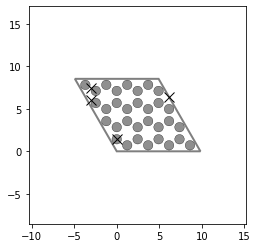

In [9]:
# Import statements
from pymatgen import Structure, Lattice, MPRester, Molecule
from pymatgen.analysis.adsorption import *
from pymatgen.core.surface import generate_all_slabs
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plot_slab(G, ax,adsorption_sites=True,repeat=1)

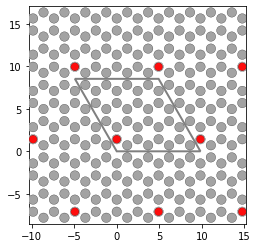

In [503]:
fig = plt.figure()
ax = fig.add_subplot(111)
adsorbate = Molecule("O", [[0, 0, 0]])
asf_G = AdsorbateSiteFinder(G)
ads_structs = asf_G.generate_adsorption_structures(adsorbate, 
                                                        repeat=[1,1,1])
plot_slab(ads_structs[0], ax, adsorption_sites=False, decay=0.09)

In [481]:
view2D(ads_structs[2])

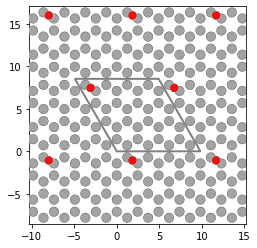

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
adsorbate = Molecule("O", [[0, 0, 0]])
asf_G = AdsorbateSiteFinder(G)
ads_structs = asf_G.generate_adsorption_structures(adsorbate, repeat=[1, 1, 1],\
                                                   find_args={"no_obtuse_hollow":False})


plot_slab(ads_structs[1], ax, adsorption_sites=False, decay=0.09)

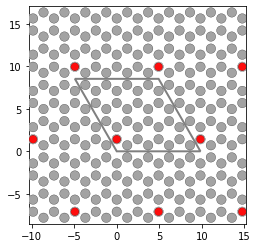

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_slab(ads_structs[0], ax, adsorption_sites=False, decay=0.09)

In [488]:
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, Structure, Lattice

lattice = Lattice.cubic(5.46873)
Si = Structure(lattice, ["Si", "Si", "Si", "Si", 
                         "Si", "Si", "Si", "Si"],
               [[0.00000, 0.00000, 0.50000],
                [0.75000, 0.75000, 0.75000],
                [0.00000, 0.50000, 0.00000],
                [0.75000, 0.25000, 0.25000],
                [0.50000, 0.00000, 0.00000],
                [0.25000, 0.75000, 0.25000],
                [0.50000, 0.50000, 0.50000],
                [0.25000, 0.25000, 0.75000]])

In [489]:
slabgen = SlabGenerator(Si, (1,1,1), 10, 10)
print("Notice now there are actually now %s terminations that can be \
generated in the (111) direction for diamond Si" %(len(slabgen.get_slabs())))

Notice now there are actually now 2 terminations that can be generated in the (111) direction for diamond Si


In [494]:
slabG = SlabGenerator(G,(1,1,1),10,10)

In [44]:
adSites = asf_G.find_adsorption_sites(no_obtuse_hollow=False)
adSites
# adSites['bridge'][0]

{'ontop': [array([-2.33486982e-16,  1.42028166e+00,  4.50000000e+00])],
 'bridge': [array([-3.075     ,  7.45647873,  4.5       ]),
  array([6.15      , 6.39126748, 4.5       ]),
  array([-3.075     ,  6.03619706,  4.5       ])],
 'hollow': [array([-3.28      ,  6.62798109,  4.5       ]),
  array([-2.87      ,  5.91784026,  4.5       ])],
 'all': [array([-2.33486982e-16,  1.42028166e+00,  4.50000000e+00]),
  array([-3.075     ,  7.45647873,  4.5       ]),
  array([6.15      , 6.39126748, 4.5       ]),
  array([-3.075     ,  6.03619706,  4.5       ]),
  array([-3.28      ,  6.62798109,  4.5       ]),
  array([-2.87      ,  5.91784026,  4.5       ])]}

In [534]:
# dopant = Molecule('B',[[0,0,0]])
dope_structs = asf_G.generate_substitution_structures('B','C')

In [508]:
import random

random.sample(adSites['ontop'],2)

# adSites['ontop'][0]

[array([-1.23      ,  4.97098582,  4.5       ]),
 array([-2.46      ,  7.10140831,  4.5       ])]

In [66]:
lattice = Lattice.hexagonal(2.46,5)
G = Structure(lattice, ["C", "C"], [[1/3,2/3,1/2],[2/3,1/3,1/2]])
G.make_supercell([4,4,1])

In [64]:
G.append('O',adSites['bridge'][1],coords_are_cartesian=True)

In [65]:
view2D(G)

In [71]:
G.sites

[PeriodicSite: C (0.0000, 1.4203, 2.5000) [0.0833, 0.1667, 0.5000],
 PeriodicSite: C (-1.2300, 3.5507, 2.5000) [0.0833, 0.4167, 0.5000],
 PeriodicSite: C (-2.4600, 5.6811, 2.5000) [0.0833, 0.6667, 0.5000],
 PeriodicSite: C (-3.6900, 7.8115, 2.5000) [0.0833, 0.9167, 0.5000],
 PeriodicSite: C (2.4600, 1.4203, 2.5000) [0.3333, 0.1667, 0.5000],
 PeriodicSite: C (1.2300, 3.5507, 2.5000) [0.3333, 0.4167, 0.5000],
 PeriodicSite: C (0.0000, 5.6811, 2.5000) [0.3333, 0.6667, 0.5000],
 PeriodicSite: C (-1.2300, 7.8115, 2.5000) [0.3333, 0.9167, 0.5000],
 PeriodicSite: C (4.9200, 1.4203, 2.5000) [0.5833, 0.1667, 0.5000],
 PeriodicSite: C (3.6900, 3.5507, 2.5000) [0.5833, 0.4167, 0.5000],
 PeriodicSite: C (2.4600, 5.6811, 2.5000) [0.5833, 0.6667, 0.5000],
 PeriodicSite: C (1.2300, 7.8115, 2.5000) [0.5833, 0.9167, 0.5000],
 PeriodicSite: C (7.3800, 1.4203, 2.5000) [0.8333, 0.1667, 0.5000],
 PeriodicSite: C (6.1500, 3.5507, 2.5000) [0.8333, 0.4167, 0.5000],
 PeriodicSite: C (4.9200, 5.6811, 2.5000) [0

In [509]:
G.append('O',random.sample(adSites['ontop'],2),coords_are_cartesian=True)

In [510]:
G

IndexError: index 2 is out of bounds for axis 0 with size 2

In [177]:
from pymatgen.transformations.advanced_transformations import SlabTransformation
miller_index = (0,0,0)
min_slab_size = 5  # in Angstroms
min_vacuum_size = 20  # in Angstroms

trans = SlabTransformation(miller_index, min_slab_size, min_vacuum_size, primitive=True,center_slab=False)

In [178]:
mod_G_surface = trans.apply_transformation(G)

ZeroDivisionError: division by zero

In [ ]:
view2D(mod_G_surface)